In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

from imblearn.over_sampling import SMOTE
from pzflow import Flow
import jax.numpy as jnp

# TODO: SPLIT INTO "TRAINING" AND "TESTING"!!!
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")


import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns


In [3]:
bank_and_tns_df = pd.read_csv('../loci_dbs/alerce_cut/bank_and_tns_df.csv.gz', compression='gzip', index_col=0)
bank_and_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.323815,0.000616,...,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232,Yes_TNS,None,-99.00,GaiaAlerts
ZTF17aadqidc,0.118791,0.276625,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.817505,0.013288,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.00,None
ZTF17aaducdh,0.384243,0.400104,0.333333,0.083333,0.379044,0.768486,0.586268,0.218094,0.425088,0.025251,...,0.223600,0.021301,0.269098,0.174500,11.297927,0.018901,Yes_TNS,None,-99.00,GaiaAlerts
ZTF18aaaokus,1.337077,4.369050,0.320225,0.005618,0.365946,2.108598,1.640040,0.837900,-0.695091,-0.001890,...,1.217501,1.251801,1.243600,1.272200,119.727409,0.005603,Yes_TNS,None,-99.00,ZTF
ZTF18aaavffc,1.251362,2.169584,0.291667,0.025000,0.338697,2.387948,2.022931,0.747013,-0.276298,-0.002842,...,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534,Yes_TNS,None,-99.00,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,-0.901772,-0.028012,...,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230,Yes_TNS,SN Ia,0.09,ZTF
ZTF22aaboiqa,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,-1.169788,-0.029534,...,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034,Yes_TNS,None,-99.00,ANTARES
ZTF22aabovlw,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,-1.919301,0.000368,...,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910,Yes_TNS,None,-99.00,ANTARES


In [4]:
Counter(bank_and_tns_df['tns_cls'])

Counter({'None': 3816,
         'TDE': 20,
         'SN Ia': 1098,
         'SN II': 243,
         'SN Ia-pec': 10,
         'SN IIn': 59,
         'SN Ia-91T-like': 37,
         'SN IIP': 14,
         'CV': 8,
         'SN': 5,
         'SLSN-I': 11,
         'SN Ib': 25,
         'SLSN-II': 14,
         'Varstar': 2,
         'SN IIb': 21,
         'SN Ic-BL': 14,
         'SN Ic': 21,
         'AGN': 7,
         'SN Ia-CSM': 4,
         'SN Iax[02cx-like]': 3,
         'Nova': 3,
         'SN Ia-91bg-like': 6,
         'SN Ib-pec': 2,
         'SN I': 6,
         'SN II-pec': 2,
         'SN Ib/c': 5,
         'Other': 5,
         'SN Ibn': 7,
         'SN Icn': 1,
         'SN IIn-pec': 1,
         'SN Ia-SC': 2})

In [5]:
# Cut classes with less than 4 occurances
                                      
# filter the DataFrame based on the occurrence count of labels in "tns_cls" column
bank_and_tns_df_cut = bank_and_tns_df.groupby('tns_cls').filter(lambda x: len(x) >= 14)
Counter(bank_and_tns_df_cut.tns_cls)

Counter({'None': 3816,
         'TDE': 20,
         'SN Ia': 1098,
         'SN II': 243,
         'SN IIn': 59,
         'SN Ia-91T-like': 37,
         'SN IIP': 14,
         'SN Ib': 25,
         'SLSN-II': 14,
         'SN IIb': 21,
         'SN Ic-BL': 14,
         'SN Ic': 21})

In [6]:
# split the data into training and testing sets
bank_and_tns_df_cut_train_df, bank_and_tns_df_cut_test_df = train_test_split(bank_and_tns_df_cut, 
                                                                             test_size=0.30, 
                                                                             random_state=10)

In [7]:
bank_and_tns_df_cut_train_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aciuuks,0.316088,0.353421,0.333333,0.000000,0.346037,0.632175,0.546621,0.289869,-0.905546,0.012960,...,0.517599,0.491701,0.567400,0.076399,31.536662,0.139680,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aaydumh,0.237472,0.503993,0.384615,0.000000,0.243716,0.474943,0.407579,0.271858,-1.017295,0.001209,...,0.704800,0.551600,0.597300,0.385601,147.285516,0.413932,Yes_TNS,None,-99.00000,ALeRCE
ZTF20aconebc,0.291277,0.494884,0.166667,0.000000,0.330584,0.582554,0.544017,0.197184,2.991826,0.021715,...,0.155300,0.224300,0.152802,0.109200,20.071106,0.082607,No_TNS,None,-99.00000,None


In [8]:
Counter(bank_and_tns_df_cut_train_df.tns_cls)

Counter({'None': 2656,
         'SN Ia': 777,
         'SN II': 175,
         'SN Ib': 19,
         'SN IIP': 9,
         'TDE': 12,
         'SN IIn': 44,
         'SLSN-II': 11,
         'SN IIb': 15,
         'SN Ic': 12,
         'SN Ic-BL': 9,
         'SN Ia-91T-like': 28})

In [9]:
bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df.tns_cls == 'SN Ia'][lc_and_host_features].iloc[0:5, :]

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,6.41716,28.099199,0.218201,0.604300,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821
ZTF21aatvcdl,1.001925,0.535585,0.384615,0.076923,0.355134,2.003849,1.392731,0.589785,1.890188,0.011990,...,3.86514,13.535500,0.170500,0.299500,0.310101,0.245600,0.215601,0.188101,1.118396,0.810604
ZTF21aagydov,0.344995,0.334842,0.500000,0.000000,0.358446,0.689991,0.612874,0.340182,-0.991203,0.018415,...,7.20253,21.644100,0.246799,0.510101,0.414299,0.434700,0.411800,0.404699,37.399125,0.084282
ZTF21abvctva,0.344452,0.366860,0.333333,0.000000,0.403889,0.688904,0.678656,0.586430,-1.910321,0.037600,...,8.22016,15.923000,0.151001,0.674500,0.704498,0.576401,0.794699,0.700800,46.946198,0.142391
ZTF21acinvvh,0.375281,0.439512,0.555556,0.000000,0.429559,0.750563,0.685636,0.534871,-1.665533,0.012003,...,11.41930,19.839800,0.230500,0.869499,0.936400,0.999901,0.978700,0.978800,51.429209,1.803869


In [ ]:
%%time
n_epochs = 500

start_idx_l = list(np.arange(0, 120, 5)) 
end_idx_l = list(np.arange(5, 125, 5))

fullsamples_all_dim_l = []
for start, end in zip(start_idx_l, end_idx_l):
    start_idx, end_idx = start, end
    print("\nSTART:", start, "END:", end)
    
    # # PZFLOW the data - even class distr
    flow = Flow(lc_and_host_features[start_idx:end_idx])

    df_list = []
    for SNtype in list(np.unique(bank_and_tns_df_cut.tns_cls)):#, 'SN II', 'SN Ic']:
        print(SNtype)
        cls_df = bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df['tns_cls'] == SNtype][lc_and_host_features].iloc[:, start_idx:end_idx]
        #print(cls_df)
        #print("length cls_df", len(cls_df))
        
        #feat_x = lc_and_host_features[start_idx:end_idx][0]
        #feat_y = lc_and_host_features[start_idx:end_idx][1]
        #plt.hist2d(cls_df[feat_x], cls_df[feat_y], bins=200)
        #plt.xlabel(feat_x)
        #plt.ylabel(feat_y)
        #plt.show()

        losses = flow.train(cls_df, verbose=False, epochs=n_epochs)

        #plt.plot(losses)
        #plt.xlabel("Epoch")
        #plt.ylabel("Training loss")
        #plt.show()

        samples = flow.sample(3039-len(cls_df), seed=10)
        #print("length samples", len(samples))
        
        #plt.hist2d(samples[feat_x], samples[feat_y], bins=200)
        #plt.xlabel(feat_x)
        #plt.ylabel(feat_y)
        #plt.show()

        if end_idx==10:
            samples['tns_cls'] = SNtype
        df_list.append(samples)
    fullsamples = pd.concat(df_list)
    fullsamples_all_dim_l.append(fullsamples)
    fullsamples_all_dim_df = pd.concat(fullsamples_all_dim_l, axis=1)
    
X_resampled = fullsamples_all_dim_df.copy().iloc[:, 0:end_idx]

#keep existing ztfids, and make fake ones for upsampled
from faker import Faker
fake = Faker()
# generate a list of 100 fake strings with the pattern 'ZTFabcXXXXX'
fake_strings = ['ZTFabc' + str(fake.unique.random_int(min=0, max=99999)).zfill(5) for _ in range(len(X_resampled))]
X_resampled_index = list(fake_strings)

X_resampled['ztf_object_id'] = X_resampled_index
X_resampled = X_resampled.set_index('ztf_object_id')

y_resampled = fullsamples_all_dim_df['tns_cls']


START: 0 END: 5
None


In [ ]:
X_resampled

In [ ]:
y_resampled

In [40]:
# Make dataset_bank_orig the PZFLOW resampled

dataset_bank_orig_train = pd.concat([bank_and_tns_df_cut_train_df.iloc[:, 0:120], X_resampled]) #X_resampled.copy()
dataset_label_orig_train = list(bank_and_tns_df_cut_train_df['tns_cls'])+ list(y_resampled) #list(y_resampled.copy())

dataset_bank_orig_test = bank_and_tns_df_cut_test_df.iloc[:, :120]
dataset_label_orig_test = bank_and_tns_df_cut_test_df['tns_cls']

len_fill_train = len(X_resampled)#-len(bank_and_tns_df_cut_train_df)
len_fill_test = len(X_resampled)#-len(bank_and_tns_df_cut_test_df)

dataset_bank_orig = pd.concat([dataset_bank_orig_train, dataset_bank_orig_test], axis=0)

# dataset_bank_tns_df
dataset_bank_tns_df_resampled_train = dataset_bank_orig_train.copy()
dataset_bank_tns_df_resampled_train['has_tns'] = list(bank_and_tns_df_cut_train_df['has_tns'])+list(['Fake']*len_fill_train)
dataset_bank_tns_df_resampled_train['tns_cls'] = dataset_label_orig_train
dataset_bank_tns_df_resampled_train['spec_z'] = list(bank_and_tns_df_cut_train_df['spec_z'])+list([-99.0]*len_fill_train)
dataset_bank_tns_df_resampled_train['report_group'] = list(bank_and_tns_df_cut_train_df['report_group'])+list(['None']*len_fill_train)

dataset_bank_tns_df_resampled_test = dataset_bank_orig_test.copy()
dataset_bank_tns_df_resampled_test['has_tns'] = list(bank_and_tns_df_cut_test_df['has_tns'])
dataset_bank_tns_df_resampled_test['tns_cls'] =  list(bank_and_tns_df_cut_test_df['tns_cls'])
dataset_bank_tns_df_resampled_test['spec_z'] = list(bank_and_tns_df_cut_test_df['spec_z'])
dataset_bank_tns_df_resampled_test['report_group'] = list(bank_and_tns_df_cut_test_df['report_group'])

pzflow_suffix = f'PZFLOW_train_test_70-30_epochs{n_epochs}'
dataset_bank_tns_df_resampled_train.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_tns_df_resampled_test.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip')


dataset_bank_tns_df_resampled = pd.concat([dataset_bank_tns_df_resampled_train, dataset_bank_tns_df_resampled_test], axis=0)
dataset_bank_tns_df = dataset_bank_tns_df_resampled.copy()


# dataset_bank_orig_host_ra_dec_resampled
dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[['raMean', 'decMean']]

# dataset_bank_orig_host_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_train = dataset_bank_orig_host_ra_dec_resampled_train

# dataset_bank_orig_host_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_test = dataset_bank_orig_host_ra_dec_resampled_test

# dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_orig_host_ra_dec_train, dataset_bank_orig_host_ra_dec_test], axis=0)
# dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[~dataset_bank_orig_host_ra_dec.isnull().any(axis=1)]


# dataset_bank_orig_transient_ra_dec
dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[['ra', 'dec']]

# dataset_bank_orig_transient_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_train = dataset_bank_orig_transient_ra_dec_resampled_train

# dataset_bank_orig_transient_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_test = dataset_bank_orig_transient_ra_dec_resampled_test

# dataset_bank_orig_transient_ra_dec = pd.concat([dataset_bank_orig_transient_ra_dec_train, dataset_bank_orig_transient_ra_dec_test], axis=0)
# dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[~dataset_bank_orig_transient_ra_dec.isnull().any(axis=1)]


# # Save full dfs
dataset_bank_orig.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_tns_df.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_orig_host_ra_dec.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_host_ra_dec_{pzflow_suffix}.csv.gz', compression='gzip')
dataset_bank_orig_transient_ra_dec.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_transient_ra_dec_{pzflow_suffix}.csv.gz', compression='gzip')


# Uncomment if I don't use SMOTE

# dataset_bank_orig = bank_and_tns_df.iloc[:, :120]
# dataset_label_orig = bank_and_tns_df.iloc[:, -3] #tns_cls
# dataset_bank_tns_df = dataset_bank_tns_df
# dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec
# dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec


dataset_bank_orig = dataset_bank_orig_train
dataset_label_orig = dataset_label_orig_train
# Save pickle
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_{pzflow_suffix}.pkl', 'wb') as f:
    pickle.dump(dataset_label_orig, f)

dataset_bank_orig

NameError: name 'dataset_bank_orig_host_ra_dec' is not defined

In [37]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abmgtat,0.121904,0.230847,0.333333,0.000000,0.261333,0.243809,0.230761,0.113331,-0.219986,0.002361,...,0.489399,0.549101,0.482800,0.428999,45.550070,0.036651,Yes_TNS,None,-99.0000,ALeRCE
ZTF18achdfqm,0.470350,0.474306,0.333333,0.000000,0.417916,0.940701,0.908838,0.707936,-1.630949,0.010391,...,0.591801,0.621698,0.693800,0.750700,4.841876,0.268249,No_TNS,None,-99.0000,None
ZTF21aagsihi,1.877941,1.139061,0.375000,0.000000,0.450437,3.729228,3.119188,2.198104,-1.478907,0.039536,...,0.743299,0.771400,0.788401,0.605900,63.663109,0.048331,Yes_TNS,SN Ia,0.0237,ATLAS
ZTF19aapswkx,0.186474,0.116516,0.500000,0.000000,0.418552,0.372948,0.372948,0.294826,-4.158978,0.002786,...,0.277401,0.336700,0.177801,0.333200,40.375798,0.051956,Yes_TNS,None,-99.0000,ZTF
ZTF20aclkhnm,0.739245,1.139875,0.166667,0.083333,0.395673,1.478491,1.095229,0.561468,1.248835,-0.021029,...,0.417900,0.077301,1.179501,1.208699,97.442370,0.329514,Yes_TNS,None,-99.0000,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc46699,1.717156,2.738399,0.479436,-0.000045,0.483922,1.677420,1.486856,1.091007,-1.582809,0.003678,...,NaN,NaN,NaN,NaN,NaN,NaN,Fake,SN IIP,-99.0000,None
ZTFabc19452,0.910859,0.654576,0.465073,0.000030,0.425179,3.392730,1.394401,2.377769,-2.149212,0.011123,...,NaN,NaN,NaN,NaN,NaN,NaN,Fake,SN IIP,-99.0000,None
ZTFabc45529,0.555763,2.370729,0.446377,0.005881,0.498159,1.371141,3.085227,0.827636,-2.636625,0.012939,...,NaN,NaN,NaN,NaN,NaN,NaN,Fake,SN IIP,-99.0000,None


In [38]:
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aaybwth,0.384511,0.549172,0.250000,0.125000,0.324167,0.769022,0.619796,0.227901,3.039816,-0.000004,...,0.065300,0.089100,0.114300,0.066299,18.578022,0.023904,Yes_TNS,None,-99.0,ZTF
ZTF21abhvfrj,0.477448,1.131876,0.090909,0.090909,0.329433,0.954895,0.633796,0.214027,5.379689,-0.001774,...,0.904800,1.048300,0.646000,-3.536699,11.699969,0.344573,Yes_TNS,None,-99.0,ALeRCE
ZTF20acngnvf,0.221461,0.330890,0.235294,0.058824,0.311743,0.442923,0.306310,0.137998,0.532772,0.001336,...,-0.086601,-0.048399,-0.113600,-0.270000,38.753182,2.917582,No_TNS,None,-99.0,None
ZTF20aciucub,0.223271,0.301653,0.285714,0.000000,0.343634,0.446543,0.400569,0.169672,1.121545,0.007691,...,0.836599,0.839901,0.759600,0.988201,57.223518,0.566740,Yes_TNS,None,-99.0,ALeRCE
ZTF21abcfnuk,0.240122,0.239833,0.285714,0.000000,0.402769,0.480244,0.435988,0.232947,-0.639529,0.017278,...,0.705400,0.707901,0.560101,0.530401,15.985091,0.185905,Yes_TNS,None,-99.0,SGLF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abtigie,0.077746,0.079083,0.500000,0.000000,0.284671,0.155493,0.155493,0.109875,-2.236207,-0.006605,...,0.089699,0.047300,0.053600,-0.127201,15.703114,0.500968,No_TNS,None,-99.0,None
ZTF22aaacmhr,0.345825,0.247437,0.400000,0.000000,0.412768,0.691650,0.691650,0.431721,-1.431617,0.033978,...,0.433800,0.440701,0.377600,0.237999,65.170156,0.219945,Yes_TNS,None,-99.0,ATLAS
ZTF21aafdwwx,0.475299,0.239554,0.333333,0.000000,0.370601,0.950598,0.893707,0.381695,-0.014211,-0.005429,...,0.529001,0.271400,0.431000,0.076199,17.544622,0.590112,Yes_TNS,None,-99.0,ALeRCE


In [ ]:
dataset_bank_orig

In [50]:
#keep existing ztfids, and make fake ones for upsampled
from faker import Faker
fake = Faker()
# generate a list of 100 fake strings with the pattern 'ZTFabcXXXXX'
fake_strings = ['ZTFabc' + str(fake.unique.random_int(min=0, max=99999)).zfill(5) for _ in range(len(X_resampled))]
X_resampled_index = list(fake_strings)

X_resampled['ztf_object_id'] = X_resampled_index
X_resampled = X_resampled.set_index('ztf_object_id')
X_resampled

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r
ztf_object_id,,,,,
ZTFabc14278,0.715103,0.437116,0.167203,0.000103,0.399698
ZTFabc35593,1.302310,2.782566,0.208666,0.000255,0.418026
ZTFabc00479,0.850817,1.011817,0.107652,0.026920,0.410585
ZTFabc30604,1.285417,2.725688,0.506836,0.012400,0.485150
ZTFabc22444,1.353309,1.829688,0.510265,0.033779,0.439082
...,...,...,...,...,...
ZTFabc97824,1.696530,2.764739,0.452448,-0.002268,0.483182
ZTFabc02222,1.270016,0.959895,0.462645,-0.000876,0.410411
ZTFabc16390,0.859053,2.485825,0.452502,0.012260,0.485017


In [51]:
y_resampled

NameError: name 'y_resampled' is not defined

In [20]:
fullsamples

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,tns_cls
0,0.978354,0.392155,0.150437,0.038688,0.410376,SLSN-II
1,1.738487,2.987346,0.190964,0.001565,0.390280,SLSN-II
2,1.447727,1.334414,0.083041,0.061069,0.458118,SLSN-II
3,1.146748,2.901535,0.509351,0.053199,0.484730,SLSN-II
4,1.801508,1.336284,0.507680,0.070325,0.423108,SLSN-II
...,...,...,...,...,...,...
3023,1.739501,2.803395,0.386870,0.001293,0.482321,SN IIP
3024,1.767018,1.084811,0.444470,0.023260,0.406640,SN IIP
3025,0.919192,2.226954,0.427161,0.033991,0.498811,SN IIP
3026,1.867690,2.219121,0.402362,0.013529,0.479807,SN IIP


In [26]:
test = list(bank_and_tns_df_cut_train_df['tns_cls']) + list(fullsamples['tns_cls'])
test

['None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN IIb',
 'None',
 'None',
 'SN Ia',
 'SN IIn',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN II',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN Ia',
 'SN Ic',
 'SN II',
 'None',
 'SN Ic-BL',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN IIb',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN IIP',
 'None',
 'SN Ic',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 '

In [28]:
Counter(test)

Counter({'None': 3039,
         'SN Ia': 882,
         'SN II': 3039,
         'SN IIb': 17,
         'SN IIn': 50,
         'SN Ic': 16,
         'SN Ic-BL': 12,
         'SN IIP': 3039,
         'SLSN-II': 3039,
         'SN Ia-91T-like': 31,
         'TDE': 13,
         'SN Ib': 20})

In [11]:
fullsamples

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,tns_cls
0,0.290674,0.244230,0.400555,-0.000213,0.394815,None
1,0.257875,0.535831,0.198670,-0.000383,0.396284,None
2,0.363049,0.475951,0.135078,0.124792,0.345644,None
3,0.312768,0.499008,0.251314,-0.000035,0.436670,None
4,0.396996,0.507696,0.402063,0.000096,0.404886,None
...,...,...,...,...,...,...
3798,0.538567,0.371713,0.241977,-0.000364,0.419730,TDE
3799,1.184112,0.396021,0.415824,-0.000322,0.426747,TDE
3800,0.408891,-0.050488,0.233946,-0.001328,0.353410,TDE
3801,0.763960,0.047038,0.219563,-0.000519,0.392618,TDE


SN Ia


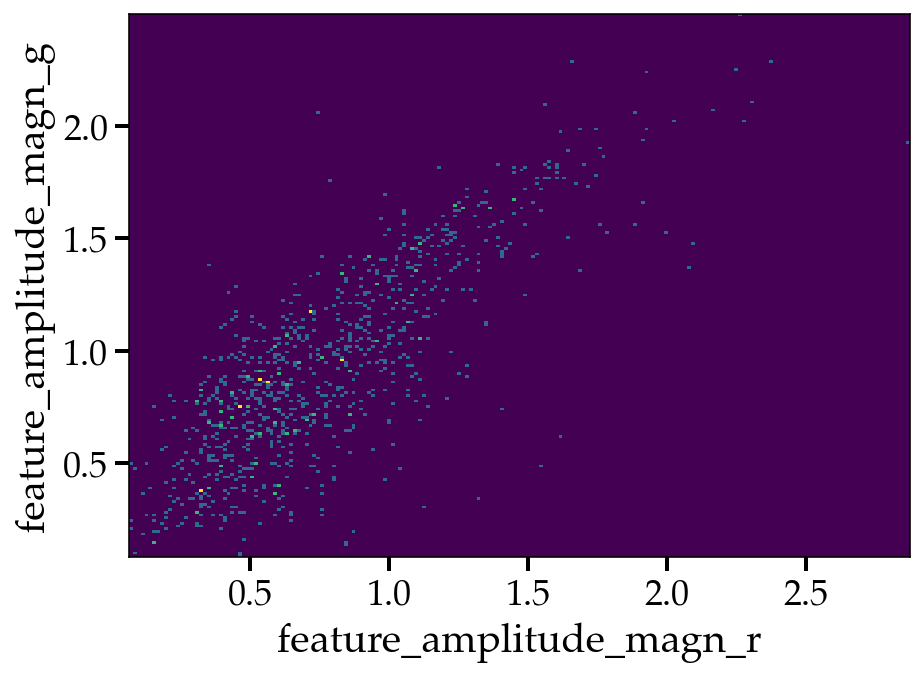

Training 500 epochs 
Loss:
(0) 2.4273
(1) 2.3039
(26) 1.1284
(51) 0.7372
(76) 0.4720
(101) 0.4041
(126) 0.3516
(151) 0.3387
(176) 0.3425
(201) 0.3203
(226) 0.2917
(251) 0.3094
(276) 0.3092
(301) 0.2826
(326) 0.2987
(351) 0.2923
(376) 0.2628
(401) 0.2769
(426) 0.3073
(451) 0.2847
(476) 0.2784
(500) 0.2707


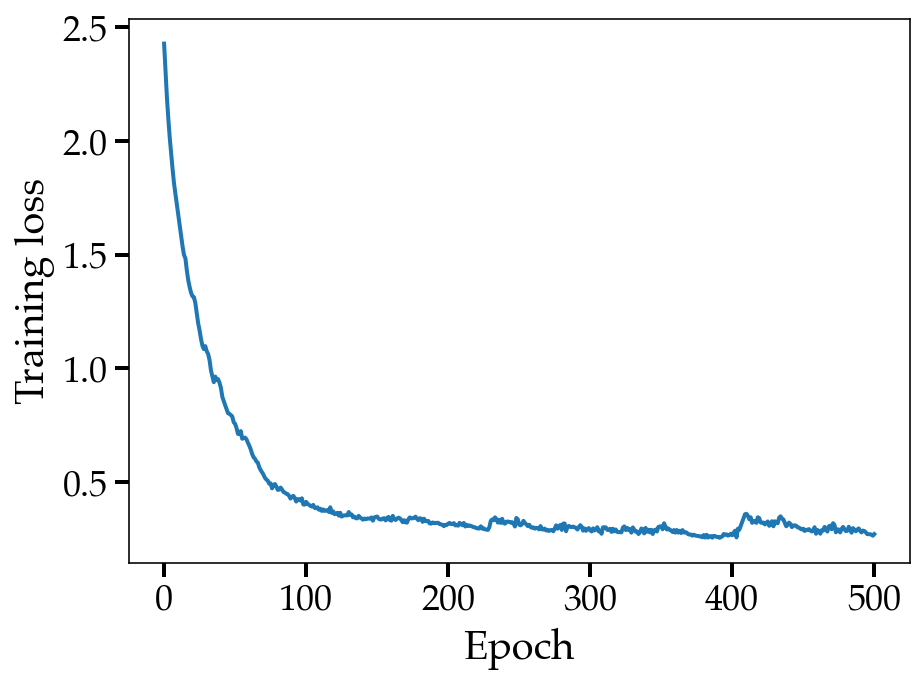

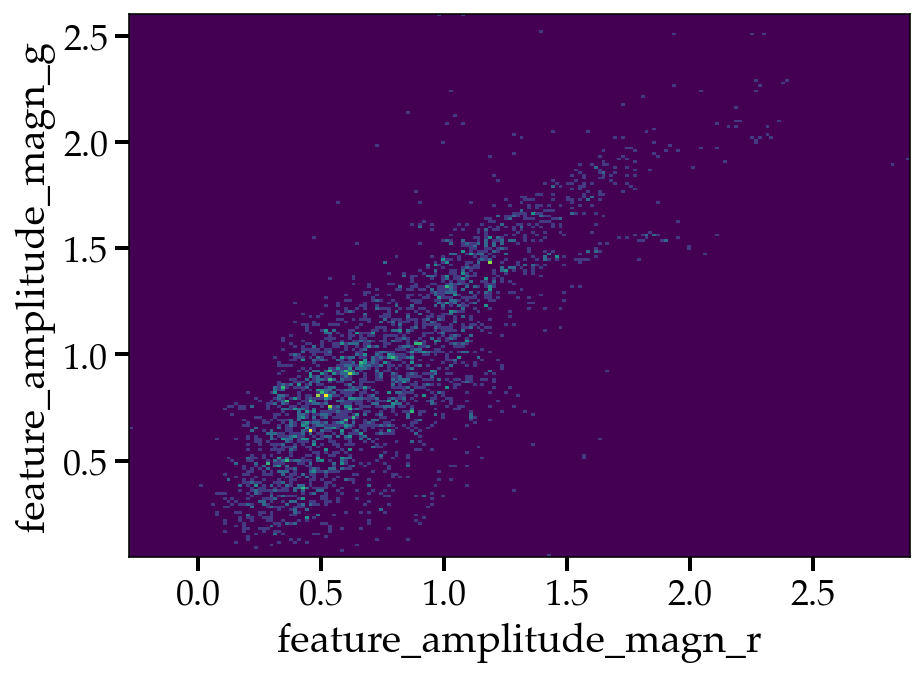

SN II


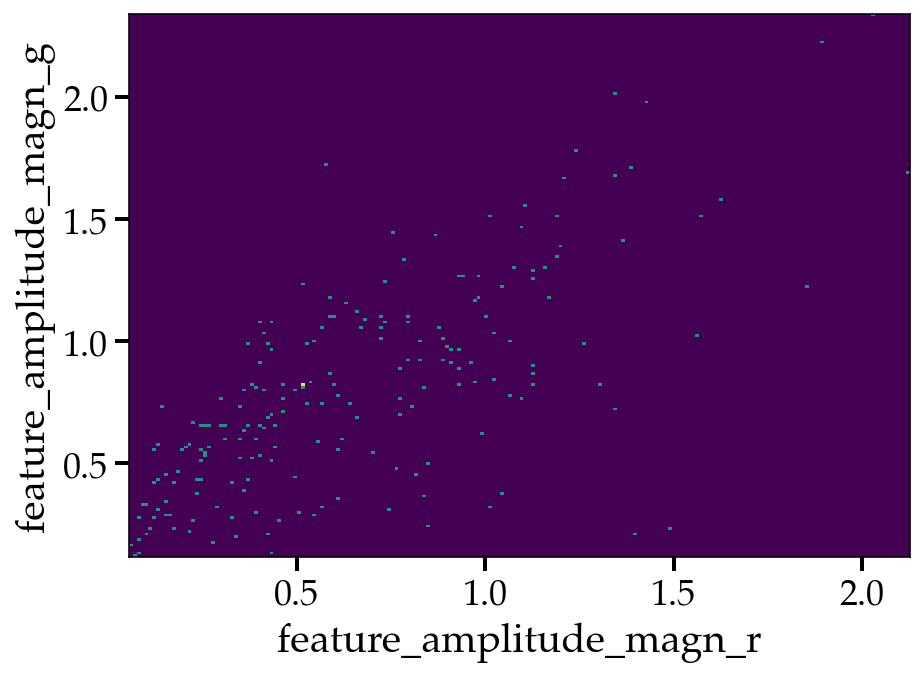

Training 500 epochs 
Loss:
(0) 0.9042
(1) 0.8953
(26) 0.3811
(51) 0.2682
(76) 0.1539
(101) 0.1586
(126) 0.1319
(151) 0.0514
(176) 0.1568
(201) 0.0770
(226) 0.0091
(251) 0.0146
(276) 0.0582
(301) 0.0189
(326) -0.0863
(351) 0.0347
(376) 0.0240
(401) 0.0748
(426) -0.0886
(451) -0.0033
(476) -0.0714
(500) 0.0196


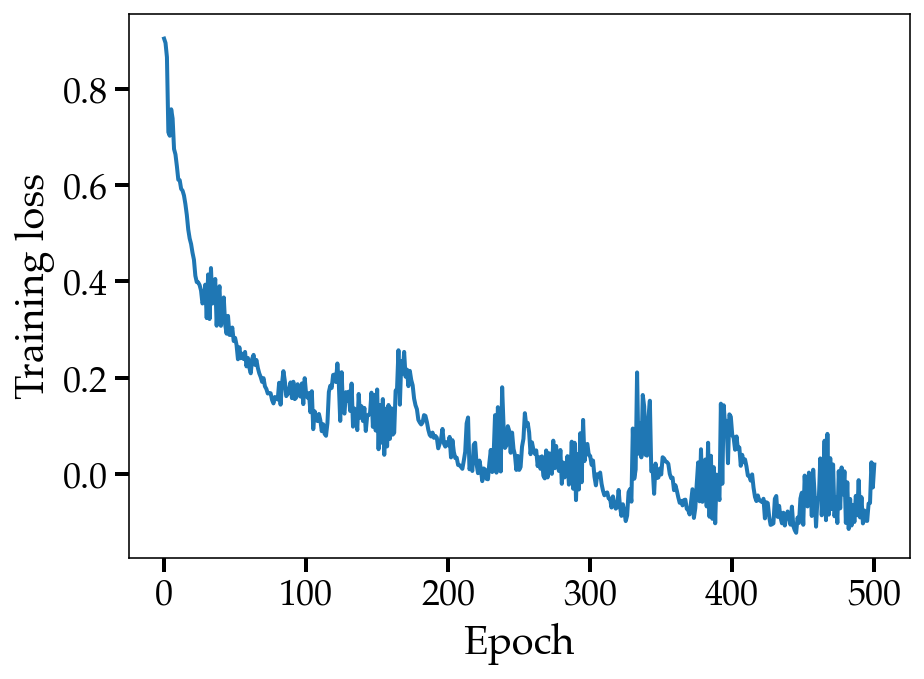

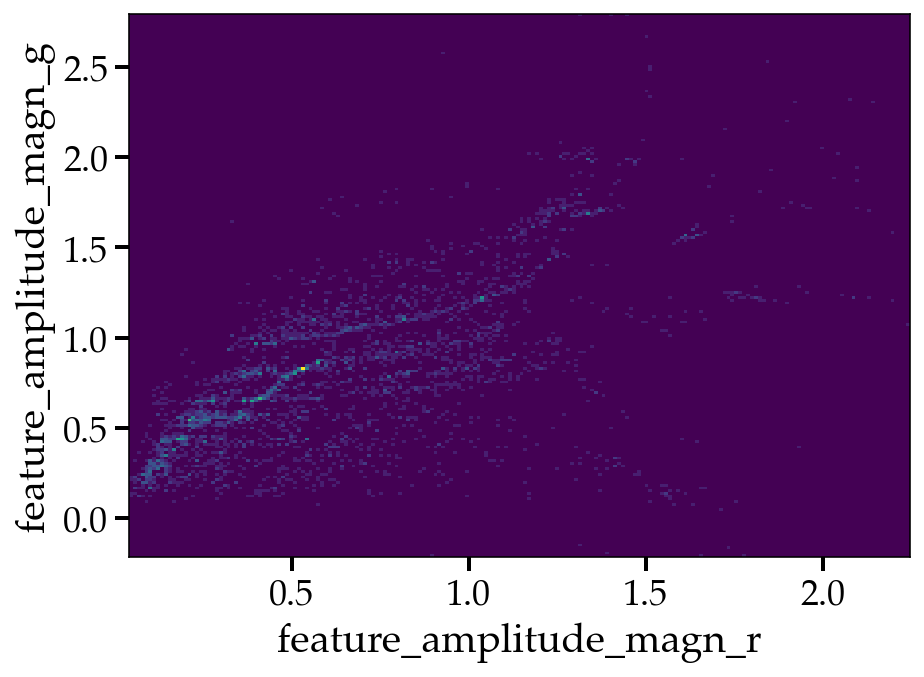

SN Ic


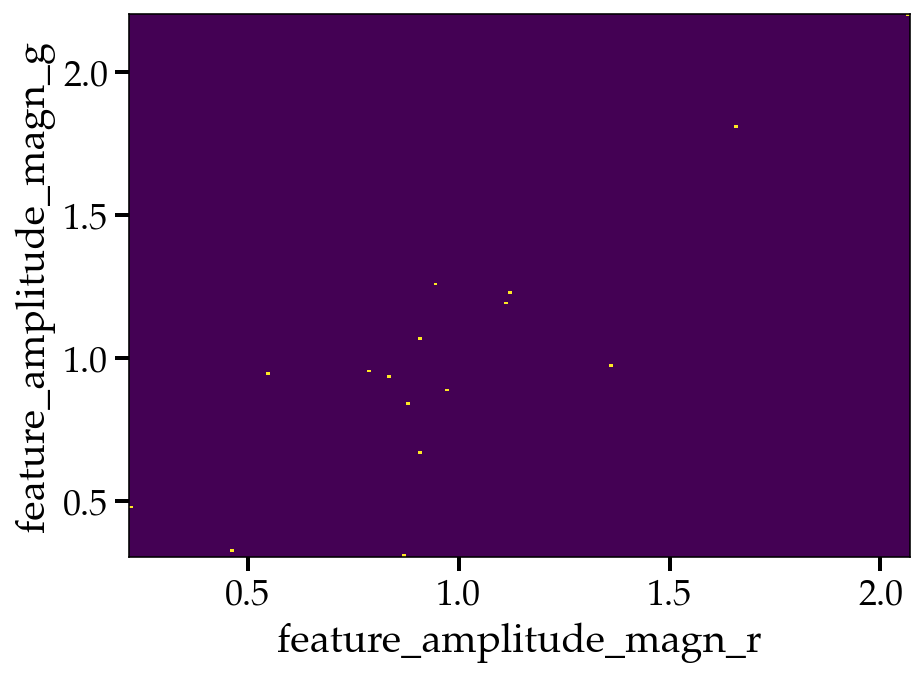

Training 500 epochs 
Loss:
(0) 2.2038
(1) 1.0260
(26) -0.3682
(51) -1.2391
(76) -1.2486
(101) -1.9384
(126) 0.2711
(151) -0.1227
(176) -1.1233
(201) -1.1241
(226) -0.5601
(251) -1.3125
(276) -1.4370
(301) -1.4285
(326) -1.8891
(351) -1.5604
(376) 0.4080
(401) -1.0519
(426) -1.8938
(451) -1.9988
(476) -1.0894
(500) -2.2110


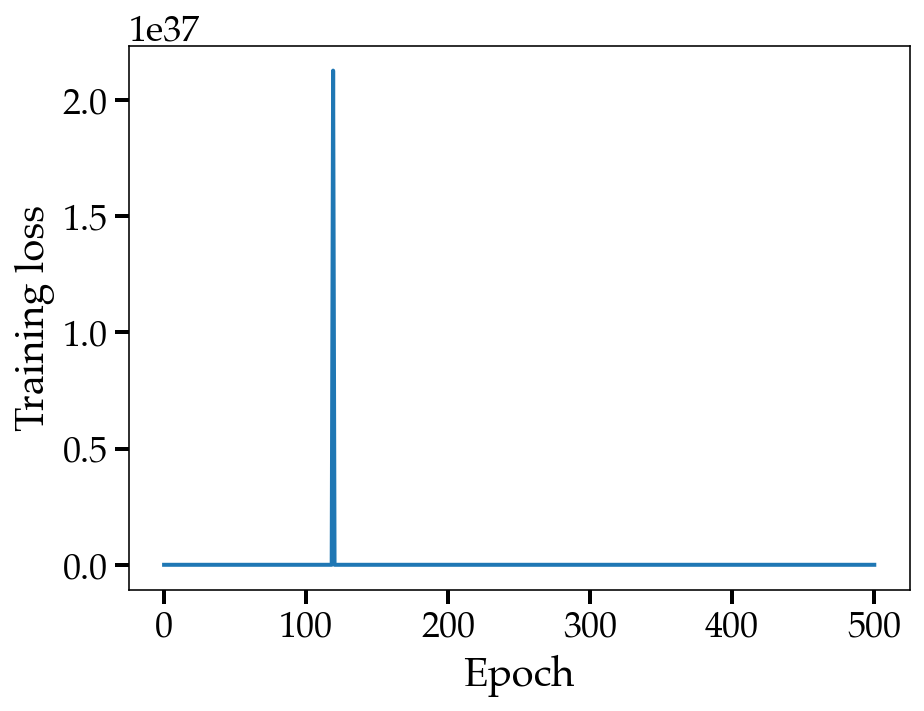

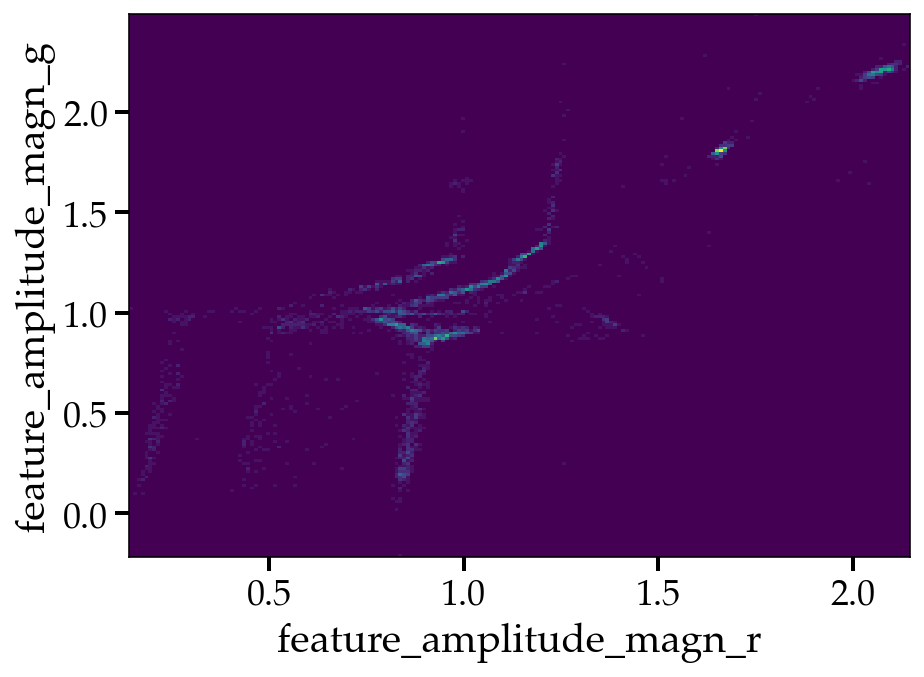

CPU times: user 32.3 s, sys: 4.05 s, total: 36.3 s
Wall time: 28.2 s


In [18]:
%%time
# # PZFLOW the data - even class distr
#flow = Flow(lc_and_host_features)
flow = Flow(["feature_amplitude_magn_r", "feature_amplitude_magn_g"])

df_list = []
for SNtype in ['SN Ia', 'SN II', 'SN Ic']:
    print(SNtype)
    cls_df = bank_and_tns_df_cut_train_df[bank_and_tns_df_cut_train_df['tns_cls'] == SNtype][lc_and_host_features]
    #print(cls_df)
    
    feat_x = "feature_amplitude_magn_r"
    feat_y = "feature_amplitude_magn_g"
    plt.hist2d(cls_df[feat_x], cls_df[feat_y], bins=200)
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.show()
    
    losses = flow.train(cls_df, verbose=True, epochs=500)
    
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.show()
    
    samples = flow.sample(3000)
    
    plt.hist2d(samples[feat_x], samples[feat_y], bins=200)
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.show()

    samples['tns_cls'] = SNtype
    df_list.append(samples)
fullsamples = pd.concat(df_list)

In [ ]:
plt.hist2d(bank_and_tns_df_cut_train_df["feature_amplitude_magn_r"], bank_and_tns_df_cut_train_df["feature_amplitude_magn_g"], bins=200)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
%%time
losses = flow.train(bank_and_tns_df_cut_train_df[lc_and_host_features], verbose=True, epochs=10)

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [ ]:
samples = flow.sample(10_000, seed=0)

In [ ]:
plt.hist2d(samples["feature_amplitude_magn_r"], samples["feature_amplitude_magn_g"], bins=200)
plt.xlabel("x")
plt.ylabel("y")
plt.show()